In [157]:
__author__ = 'aqeel'
#Note Remove This Line to Get the Figure in Seperate Window
%matplotlib inline
from math import pow
from random import randint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pylab

In [158]:
#Class to represent the state.
class State:
    def __init__(self,dealercard,playercard,Gamma):
        '''
        :param dealercard: Dealer black card
        :param playercard: player black card
        :param Gamma: discount value
        '''
        # Total of dealer cards sum
        self.dealersum=dealercard
        self.FirstDealerCard = dealercard
        # Total of Players cards
        self.playersum= playercard

        # Represent if someoe got busted
        self.terminated = False

        # No of Player draws
        self.Playerdraws=0

        # Player status
        self.PlayerBust=False

        # Dealer Status
        self.DealerBust=False

        # No of Dealer Draws
        self.Dealerdraws=0

        # discount value
        self.BaseGamma = Gamma
        
        # The Reward For The Current State
        self.Reward = 0

    def AddDrawnCardPlayer(self,value):
        '''
        add the drawn card value to player's sum and update the status of the game (ended or not ) & discount value
        :param value: signed integer from -10 to 10 represent the value and the color of the drawn card
        :return: Gamma for the current step
        '''
        if (self.terminated):
            print 'Game Ended Already'
        else:
            self.Playerdraws+=1

            if self.playersum+value>21 or self.playersum+value<1:
                #'The player Busted.'
                self.terminated=True
                self.PlayerBust=True
            else:
                self.playersum+=value

    def AddDrawnCardDealer(self,value):
        '''
        add the drawn card value to dealer's sum and update the status of the game (ended or not ) & discount value
        :param value: signed integer from -10 to 10 represent the value and the color of the drawn card
        :return: Gamma for the current step
        '''
        if (self.terminated):
            print 'Game Ended Already'
        else:
            self.Dealerdraws+=1
            self.dealersum+=value
            if self.dealersum>21 or self.dealersum<1:
                #'The Dealer Busted'
                self.terminated=True
                self.DealerBust=True
            return pow(self.BaseGamma,self.Dealerdraws)

    def __str__(self):
        return 'Reward:{},Player Draws:{},Sum:{} ## Dealer Draws:{},Sum:{},First Card:{}'\
    .format(self.Reward,self.Playerdraws,self.playersum,self.Dealerdraws,self.dealersum,self.FirstDealerCard)

In [159]:
class Values:
    
    value=0
    occurence=0
    def UpdateValues(self,value):
        self.occurence += 1
        self.value += (float(1)/float(self.occurence))*(value-self.value)
        
values = {}
def AddValue(playersum , dealercard,value):
    if playersum<1:
        return
    if (playersum,dealercard) in values.keys():
        (values[(playersum,dealercard)]).UpdateValues(value)
    else:
        tmp = Values()
        tmp.UpdateValues(value)
        values[(playersum,dealercard)] = tmp

In [160]:
def DrawBlackCard():
    '''
    simulate draw a black card from (1-10) to use for the first draw
    :return:random integer from 1-10
    '''
    return randint(1,10)

def DrawCard():
    '''
    simulate draw a (red/black) from (1-10) card. with probability 1/3 for negative value and 2/3 for positive value
    :return:random integer from (-10 to 10)
    '''
    return ( DrawBlackCard() if randint(1,3)!=1 else  DrawBlackCard()*-1)
    #return value

def CheckReward(s):
    '''
    :param s: Game State(type State)
    :return:signed integer as reward(-1,0,1))
    '''
    reward=None
    #The Game Ended Already(Someone Got Busted)
    if s.terminated:
        #The Player busted
        if s.PlayerBust:
            s.Reward=-1
        #The Dealer busted
        elif s.DealerBust:
            s.Reward=1
         #No one Got Busted
        else:
            #Player score is higher than the dealer
            if s.playersum>s.dealersum:
                s.Reward=1
            #Dealer Score is higher than the player
            elif s.dealersum>s.playersum:
                s.Reward=-1
            #Dealer and Player scores equal
            else:
                s.Reward=0
    #Return reward
    return reward
    '''
    if reward==None:
        return reward
    else:
        return pow(s.BaseGamma,s.Playerdraws)*reward
    '''

def step(s,a):
    '''
    simulate the player single step, or dealer(all steps )
    :param s: the current state
    :param a: the action 0:hit ,1:stick
    :return: s' (the new  state ) and R ( the reward )
    '''
    if s.terminated:
        print 'Game Ended Already'
        return 0
    #Player is hitting
    if a==0:
        s.AddDrawnCardPlayer(DrawCard())
        return CheckReward(s)
    #The Player Stick , Dealer is hitting.
    elif a==1:
        #if game not terminated & the dealer sum is less than 17
        while not s.terminated and s.dealersum<17:
            s.AddDrawnCardDealer(DrawCard())
        #Either the dealer got busted or got more than 17
        s.terminated=True
        return CheckReward(s)

def GetPlayerAction():
    return (1 if Easy21.playersum>17 else 0)

for i in range (0,1000):
    #---Game Started -----#
    Easy21 = State(DrawBlackCard(),DrawBlackCard(),1)
    #---Inititation values ----#
    action = GetPlayerAction()
    while not Easy21.terminated:
        step(Easy21,action)
        AddValue(Easy21.playersum,Easy21.FirstDealerCard,Easy21.Reward)
        if Easy21.terminated:
            break
        if action==1:
            break
        else:
            action=GetPlayerAction()
    #---Game Ended---#


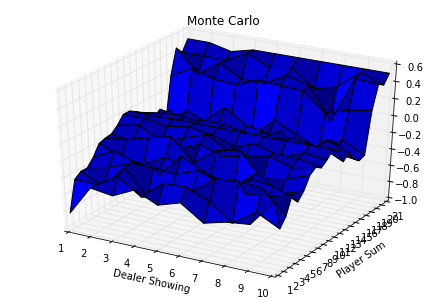

In [156]:

# plot the value function
x = range(1, 11)  # dealer
y = range(1, 22)  # player
X, Y = np.meshgrid(x, y)
Z = np.array([[0. for i in range(len(x))] for j in range(len(y))])
for i in x:
    for j in y:
        Z[j - 1][i - 1] = values[(j, i)].value
fig = pylab.figure()
ax = Axes3D(fig)
pylab.title("Monte Carlo")
ax.set_xlabel("Dealer Showing")
pylab.xlim([1, 10])
pylab.xticks(range(1, 11))
ax.set_ylabel("Player Sum")
pylab.ylim([1, 21])
pylab.yticks(range(1, 22))
ax.plot_surface(X, Y, Z, rstride=1, cstride=1)
pylab.show()